# Sparse sampling

In this page, we describe how to infer IR expansion coefficients using the sparse-sampling techiniques.

In [1]:
import sparse_ir
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

## Setup
We consider a semicircular spectral modeli (full bandwidth of 2):

$$
\rho(\omega) = \frac{2}{\pi}\sqrt{1-\omega^2}.
$$

First, we compute the numerically exact expansion coefficients $g_l$.

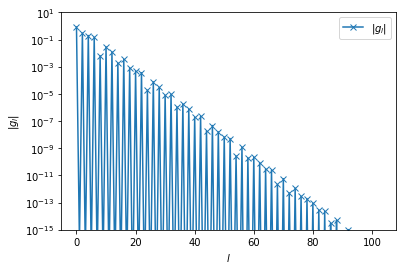

In [2]:
def rho(omega):
    if np.abs(omega) < 1:
        return (2/np.pi) * np.sqrt(1-omega**2)
    else:
        return 0.0

beta = 1000
wmax = 10
basis = sparse_ir.FiniteTempBasis("F", beta, wmax, eps=1e-15)

rhol = basis.v.overlap(rho)
gl = - basis.s * rhol

plt.semilogy(np.abs(gl), marker="x", label=r"$|g_l|$")
plt.xlabel(r"$l$")
plt.ylabel(r"$|g_l|$")
plt.ylim([1e-15, 10])
plt.legend()
plt.show()

## From sampling times

We first create a `TauSampling` object for the default sampling times.

In [3]:
smpl_tau = sparse_ir.TauSampling(basis)
print("sampling times: ", smpl_tau.sampling_points)
print("Condition number: ", smpl_tau.cond)

sampling times:  [8.31587808e-03 1.66317562e-02 5.59200332e-02 1.18143645e-01
 2.03947191e-01 3.14246915e-01 4.50258218e-01 6.13536426e-01
 8.06029765e-01 1.03014593e+00 1.28883391e+00 1.58568265e+00
 1.92503770e+00 2.31213652e+00 2.75326206e+00 3.25591383e+00
 3.82899524e+00 4.48301679e+00 5.23031657e+00 6.08530255e+00
 7.06472437e+00 8.18798420e+00 9.47749803e+00 1.09591176e+01
 1.26626234e+01 1.46222974e+01 1.68775857e+01 1.94738594e+01
 2.24632846e+01 2.59058095e+01 2.98702768e+01 3.44356665e+01
 3.96924657e+01 4.57441536e+01 5.27087701e+01 6.07205075e+01
 6.99312213e+01 8.05116904e+01 9.26523584e+01 1.06563154e+02
 1.22471811e+02 1.40619863e+02 1.61255276e+02 1.84620401e+02
 2.10933930e+02 2.40365799e+02 2.73005010e+02 3.08822305e+02
 3.47632675e+02 3.89066195e+02 4.32558093e+02 4.77367971e+02
 5.22632029e+02 5.67441907e+02 6.10933805e+02 6.52367325e+02
 6.91177695e+02 7.26994990e+02 7.59634201e+02 7.89066070e+02
 8.15379599e+02 8.38744724e+02 8.59380137e+02 8.77528189e+02
 8.9343

The condition number is around 50, indicating that 1--2 significant digits may be lost in a fit from the sampling times. Let us fit from the sampling times!

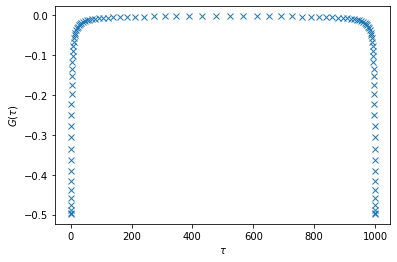

In [4]:
# Evaluate G(τ) on the sampling times
gtau_smpl = smpl_tau.evaluate(gl)
plt.plot(smpl_tau.sampling_points, gtau_smpl, marker="x", ls="")
plt.xlabel(r"$\tau$")
plt.ylabel(r"$G(\tau)$")
plt.show()

# Fit G(τ) on the sampling times
gl_reconst_from_tau = smpl_tau.fit(gtau_smpl)

## From sampling frequencies

We create a `MatsubaraSampling` object for the default sampling frequencies.

In [5]:
smpl_matsu = sparse_ir.MatsubaraSampling(basis)
print("sampling frequencies: ", smpl_matsu.sampling_points)
print("Condition number: ", smpl_matsu.cond)

sampling frequencies:  [-36361 -34629 -32897 -14203  -8629  -6089  -4627  -3671  -2991  -2481
  -2083  -1765  -1505  -1289  -1107   -953   -823   -711   -615   -533
   -461   -399   -347   -301   -261   -225   -195   -169   -147   -127
   -111    -97    -83    -73    -63    -55    -49    -41    -37    -33
    -29    -25    -23    -21    -19    -17    -15    -13    -11     -9
     -7     -5     -3     -1      1      3      5      7      9     11
     13     15     17     19     21     23     25     29     33     37
     41     49     55     63     73     83     97    111    127    147
    169    195    225    261    301    347    399    461    533    615
    711    823    953   1107   1289   1505   1765   2083   2481   2991
   3671   4627   6089   8629  14203  32897  34629  36361]
Condition number:  113.86630312218674


The condition number is slightly larger than that for the sampling times.

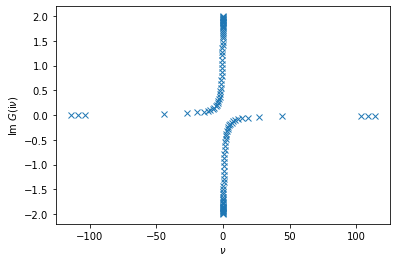

In [6]:
# Evaluate G(iv) on the sampling frequencies
giv_smpl = smpl_matsu.evaluate(gl)
plt.plot((np.pi/beta)*smpl_matsu.wn, giv_smpl.imag, marker="x", ls="")
plt.xlabel(r"$\nu$")
plt.ylabel(r"Im $G(\mathrm{i}\nu)$")
plt.show()

# Fit G(τ) on the sampling times
gl_reconst_from_matsu = smpl_matsu.fit(giv_smpl)

## Comparison with exact results
We now compare the reconstructed expansion coefficients with the exact one. For clarity, we plot only the data for even $l$.

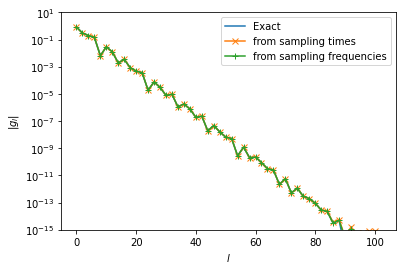

In [7]:
ls = np.arange(basis.size)
plt.semilogy(ls[::2], np.abs(gl[::2]), marker="", ls="-", label="Exact")
plt.semilogy(ls[::2], np.abs(gl_reconst_from_tau[::2]), marker="x", label="from sampling times")
plt.semilogy(ls[::2], np.abs(gl_reconst_from_matsu[::2]), marker="+", label="from sampling frequencies")
plt.xlabel(r"$l$")
plt.ylabel(r"$|g_l|$")
plt.ylim([1e-15, 10])
plt.legend()
plt.show()

We saw a perfect match! Let us plot the differences from the exact one.

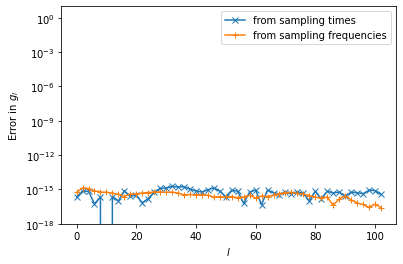

In [8]:
plt.semilogy(ls[::2], np.abs((gl_reconst_from_tau-gl)[::2]), marker="x", label="from sampling times")
plt.semilogy(ls[::2], np.abs((gl_reconst_from_matsu-gl)[::2]), marker="+", label="from sampling frequencies")
plt.xlabel(r"$l$")
plt.ylabel(r"Error in $g_l$")
plt.ylim([1e-18, 10])
plt.legend()
plt.show()